In [1]:
import datetime

import geopandas as gpd
import pandas as pd
import yaml
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
PATH_PROJECT = "/home/yoshraf/projects/mestrado/"

pd.options.display.max_columns = None

df07 = pd.read_parquet(f"{PATH_PROJECT}data/processed/dataset07.parquet")
df17 = pd.read_parquet(f"{PATH_PROJECT}data/processed/dataset17.parquet")

In [3]:
def subway_rate(df, od07=False):
    if od07:
        df = df[df["loc_domicilio_dist_metro"] >= 1000]
        df["loc_domicilio_dist_metro"] = df["loc_domicilio_dist_metro17"].values
    df = df[COLS]
    # Dropnan (viagens não realizadas)
    df = df.dropna()
    # Retira pessoas que ja moravam perto do metrô
    # Map de metro para
    df[LABEL] = df[LABEL].apply(lambda x: 1 if x == "Metrô" else 0)

    # Group by person
    df_mean = pd.DataFrame(df.groupby(IDX)[LABEL].mean())
    df_mean.columns = ["Taxa de Metrô"]
    df2 = df.merge(df_mean, on=IDX)
    df2 = df2.drop(columns=[LABEL]).drop_duplicates()
    return df2

In [4]:
def how_far(df, od07=False):
    if od07:
        df = df[df["loc_domicilio_dist_metro"] >= 1000]
        df["loc_domicilio_dist_metro"] = df["loc_domicilio_dist_metro17"].values
    df = df[COLS]
    # Dropnan (viagens não realizadas)
    df = df[df[LABEL] != 0]
    df = df.dropna()
    # Group by person
    df_sum = pd.DataFrame(df.groupby(IDX)[LABEL].sum())
    df_sum.columns = ["sum_dist_od"]
    df2 = df.merge(df_sum, on=IDX)
    df2 = df2.drop(columns=[LABEL]).drop_duplicates()
    return df2

In [5]:
def count_trip(df, od07=False):
    if od07:
        df = df[df["loc_domicilio_dist_metro"] >= 1000]
        df["loc_domicilio_dist_metro"] = df["loc_domicilio_dist_metro17"].values
    df = df[COLS]
    # Dropnan (viagens não realizadas)
    df = df[df[LABEL] != 0]
    df = df.dropna()
    # Group by person
    df = df.drop_duplicates()
#     df_mean = pd.DataFrame(df.groupby(IDX)[LABEL].mean())
#     df_sum.columns = ["sum_dist_od"]
#     df2 = df.merge(df_sum, on=IDX)
#     df2 = df2.drop(columns=[LABEL]).drop_duplicates()
    return df

In [8]:
IDX = [
    "Identifica Pessoa"
]

COLS = [
    "Identifica Pessoa",
    "Idade",
    "Gênero",
    "per Quantidade Automóvel",
    "per Renda Familiar Mensal",
    "loc_domicilio_dist_metro",
    "Total de Viagens internas"
]

LABEL = "Total de Viagens internas"

cols_rename = {
    "Identifica pessoa": "Identifica Pessoa",
    "per Renda familiar mensal": "per Renda Familiar Mensal",
    "per Quantidade de automóveis": "per Quantidade Automóvel",
    "Total de viagens da pessoa": "Total de Viagens internas"
}
df17.rename(columns = cols_rename, inplace=True)

In [18]:
df07_far = count_trip(df07, od07 = True)
df17_far = count_trip(df17)

<ipython-input-5-53dd4772c45f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["loc_domicilio_dist_metro"] = df["loc_domicilio_dist_metro17"].values


In [19]:
df07_far["OD17"] = 0
df17_far["OD17"] = 1

In [20]:
dataset = pd.concat([df07_far, df17_far])

In [21]:
dataset["T_600"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 600 else 0)
dataset["T_800"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 800 else 0)
dataset["T_1000"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 1000 else 0)

In [22]:
dataset = dataset.set_index(IDX)
dataset = pd.get_dummies(dataset, drop_first=True)

In [23]:
T = "T_600"
COLS_MODELING = ["Idade", "per Quantidade Automóvel", "per Renda Familiar Mensal", "OD17", T, "Gênero_Masculino"]
df_model = dataset[COLS_MODELING].copy()
df_model["OD17:T"] = df_model["OD17"].values * df_model[T].values
df_model = sm.add_constant(df_model)

In [26]:
res = sm.OLS(dataset[LABEL].values, df_model).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     16.33
Date:                Tue, 13 Jul 2021   Prob (F-statistic):           1.72e-21
Time:                        22:15:54   Log-Likelihood:                -12629.
No. Observations:                7373   AIC:                         2.527e+04
Df Residuals:                    7365   BIC:                         2.533e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [27]:
df_plot = pd.DataFrame(dataset.groupby(["OD17", T])[LABEL].mean()).reset_index()

In [28]:
df_plot

,OD17,T_600,Total de Viagens internas
0,0,0,2.767236
1,0,1,2.939863
2,1,0,2.670641
3,1,1,2.775596


<AxesSubplot:xlabel='OD17', ylabel='Total de Viagens internas'>

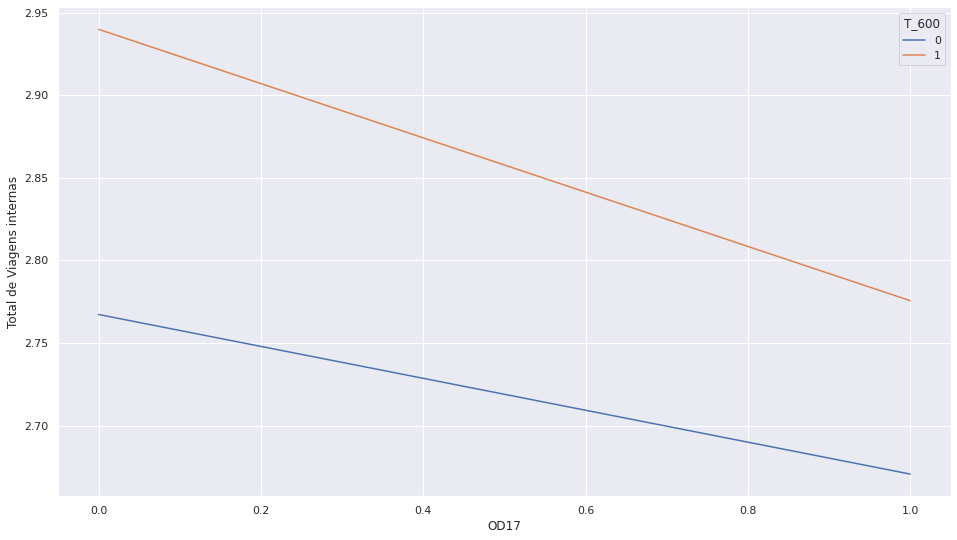

In [30]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df_plot, x="OD17", y=LABEL, hue=T)

In [142]:
# Read config
with open(f"{PATH_PROJECT}{PATH_R_CONF}{YML}", encoding="utf8") as f:
    config = yaml.load(f, Loader=yaml.FullLoader, )

# Main variables
cols = config["DATAPREP"]["FLS6641-DISCRETE-CHOICE"]["SELECT_COLUMNS"]
idx = config["DATAPREP"]["FLS6641-DISCRETE-CHOICE"]["IDX"]
mapping = config["DATAPREP"]["FLS6641-DISCRETE-CHOICE"]["ENCODING"]
cat = config["DATAPREP"]["FLS6641-DISCRETE-CHOICE"]["CATEGORICAL"]
label = config["DATAPREP"]["FLS6641-DISCRETE-CHOICE"]["LABEL"]["COLUMN"]
label_values = config["DATAPREP"]["FLS6641-DISCRETE-CHOICE"]["LABEL"]

# Filter, select and Drop Values
dataset = df[cols + [label]].drop_duplicates()

# Filling missing valuies with mean
dataset.fillna(dataset.mean(), inplace=True)
# Mapping
for k, v in mapping.items():
    dataset[k] = dataset[k].map(v)
# Main Mode
dataset = dataset[~ dataset[label].isna()]
dataset[label] = dataset[label].apply(lambda x: 1 if x == "Metrô" else 0)
# Group by person
df_mean = pd.DataFrame(dataset.groupby(["Identifica pessoa"])[label].mean())
df_mean.columns = ["Taxa de Metrô"]
dataset2 = dataset.merge(df_mean, on=["Identifica pessoa"])
dataset2 = dataset2.drop(columns=[label]).drop_duplicates()
# Convert to Datetime
dataset2["Data da entrevista"] = pd.to_datetime(
    dataset2["Data da entrevista"], format="%d%m%Y").values
# GeoJoin
gdf = gpd.GeoDataFrame(dataset2,
                       geometry=gpd.points_from_xy(dataset2["Coordenada X domicílio"],
                                                   dataset2["Coordenada Y domicílio"]))
gdf.head(5)
gdf_neigh = gpd.read_file(
    "/home/yoshraf/projects/mestrado/data/gis/od2017/Distritos_2017_region.shp")
dist = ['Campo Belo', "Santo Amaro", "Itaim Bibi"]
gdf_neigh = gdf_neigh[gdf_neigh["NomeDistri"].isin(dist)]
gdf_f = gpd.sjoin(gdf, gdf_neigh, how="inner", op='intersects')

# --------------------------
# Plot to check our filters
gdf_metro = gpd.read_file(
    f"{PATH_PROJECT}data/gis/metro/SAD69-96_SHP_estacaometro_point.shp")
lst_metro_in = [
    "ALTO DA BOA VISTA",
    "BORBA GATO",
    "BROOKLIN"
]
gdf_metro_f = gdf_metro[gdf_metro["emt_nome"].isin(lst_metro_in)]
gdf_f[f"dist_metro_key"] = gdf_f["geometry"].apply(
    lambda x: gdf_metro_f.distance(x)).min(1)
# Create dist lower than 600, 800, 1000
gdf_f["dist_metro_menor_600"] = gdf_f["dist_metro_key"].apply(lambda x: 1 if x < 600 else 0)
gdf_f["dist_metro_menor_800"] = gdf_f["dist_metro_key"].apply(lambda x: 1 if x < 800 else 0)
gdf_f["dist_metro_menor_1000"] = gdf_f["dist_metro_key"].apply(lambda x: 1 if x < 1000 else 0)
gdf_f["dist_metro_menor_1500"] = gdf_f["dist_metro_key"].apply(lambda x: 1 if x < 1500 else 0)
ax = gdf_metro_f.plot(color='red')
gdf_f.plot(
    ax = ax,
    column="dist_metro_menor_1500",
    alpha = .3)

# Time
gdf_f[gdf_f["Data da entrevista"] < datetime.datetime(2017, 11, 27)].shape
gdf_f[gdf_f["Data da entrevista"] >= datetime.datetime(2017, 11, 27)].shape
# Treatment
gdf_f[(gdf_f["dist_metro_menor_1000"] == 1) &
      (gdf_f["Data da entrevista"] < datetime.datetime(2017, 11, 27))].shape
gdf_f.shape

Tr_b = gdf_f[(gdf_f["dist_metro_menor_1500"] == 1) &
      (gdf_f["Data da entrevista"] < datetime.datetime(2017, 11, 27))]
Tr_a = gdf_f[(gdf_f["dist_metro_menor_1500"] == 1) &
      (gdf_f["Data da entrevista"] > datetime.datetime(2017, 11, 27))]
Cr_b = gdf_f[(gdf_f["dist_metro_menor_1500"] == 0) &
      (gdf_f["Data da entrevista"] < datetime.datetime(2017, 11, 27))]
Cr_a = gdf_f[(gdf_f["dist_metro_menor_1500"] == 0) &
      (gdf_f["Data da entrevista"] > datetime.datetime(2017, 11, 27))]
print(Tr_b["Taxa de Metrô"].mean())
print(Tr_a["Taxa de Metrô"].mean())
print(Cr_b["Taxa de Metrô"].mean())
print(Cr_a["Taxa de Metrô"].mean())
Tr_b.shape

# OneHotCoding
enc = OneHotEncoder(handle_unknown="error", drop="if_binary")
X_cat = pd.DataFrame(enc.fit_transform(
    dataset[cat]).toarray(), columns=enc.get_feature_names(cat))
# All Numeric types
numerics_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = pd.concat([dataset.select_dtypes(
    include=numerics_dtypes).reset_index(), X_cat], axis=1).set_index(idx)
# Split into X and y
y = dataset[[label]]
# Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

# Save datasets
X_train.to_parquet(f"{PATH_PROJECT}data/discrete_choice/X_train.parquet")
X_test.to_parquet(f"{PATH_PROJECT}data/discrete_choice/X_test.parquet")
y_train.to_parquet(f"{PATH_PROJECT}data/discrete_choice/y_train.parquet")
y_test.to_parquet(f"{PATH_PROJECT}data/discrete_choice/y_test.parquet")
print("Everything is OK!")

NameError: name 'df' is not defined